In [1]:
import torch 
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms 
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler


In [2]:
class CostumeDataset:
    def __init__(self, path, h, w):
        self.h = h
        self.w = w
        self.path = path 
        self.data = None
    
    def make_dataset(self):
        normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                                         std=[0.2, 0.2, 0.2])
        
        self.data = datasets.ImageFolder(self.path, transforms.Compose([
            transforms.Resize((self.h, self.w)), 
            # transforms.CenterCrop(224), 
            transforms.ToTensor(), 
            normalize,]))
        
        # self.class_to_idx = self.data.class_to_idx 
        # self.idx_to_class = {v: int(k) for k,v in self.class_to_idx.items()
        
        return self.data
    
    def get_data_loader(self, batch_size, num_workers=0,):
        
        if self.data is None:
            self.make_dataset()
            
        n_data = len(self.data.samples)
        indices = np.arange(n_data)
        np.random.shuffle(indices)
        sampler = SubsetRandomSampler(indices)
        data_loader = DataLoader(self.data, 
                                 batch_size=batch_size, 
                                 shuffle=False, 
                                 num_workers=num_workers,
                                 sampler=sampler)
        return data_loader 

In [3]:
batch_size = 64
h, w = 256, 128 


# Load datasets 

In [4]:
train_data = CostumeDataset(path="../data/flower_photos/train/", h=h, w=w)
train_dataloader_f = train_data.get_data_loader(batch_size=batch_size, num_workers=0, )

train_dataloader_f.dataset

Dataset ImageFolder
    Number of datapoints: 3130
    Root location: ../data/flower_photos/train/
    StandardTransform
Transform: Compose(
               Resize(size=(256, 128), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.2, 0.2, 0.2])
           )

In [5]:
train_size = int(0.9 * len(train_dataloader_f))
val_size = len(train_dataloader_f) - train_size
train_size, val_size 
train_dataloader, val_dataloader= torch.utils.data.random_split(train_dataloader_f, 
                                                                [train_size, val_size])

In [6]:
test_data = CostumeDataset(path="../data/flower_photos/test/", h=h, w=w)
test_dataloader = test_data.get_data_loader(batch_size=batch_size, num_workers=0, )

test_dataloader.dataset

Dataset ImageFolder
    Number of datapoints: 540
    Root location: ../data/flower_photos/test/
    StandardTransform
Transform: Compose(
               Resize(size=(256, 128), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.2, 0.2, 0.2])
           )

In [7]:
train_features, train_labels = next(iter(test_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()[0]
label = train_labels[0]


Feature batch shape: torch.Size([64, 3, 256, 128])
Labels batch shape: torch.Size([64])


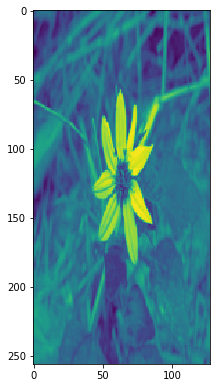

Label: 3


In [8]:
plt.figure(figsize=(10.5, 6.5))
plt.imshow(img, )
plt.show()
print(f"Label: {label}")

In [9]:
train_data.data.class_to_idx

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [10]:
n_classes = len(train_data.data.class_to_idx.keys())
n_classes

5

In [11]:
for batch, (x, y) in enumerate(train_dataloader.dataset):
    print(batch)
    print("X.shape:", x.shape)
    print("y.shape:", y.shape)
    break

0
X.shape: torch.Size([64, 3, 256, 128])
y.shape: torch.Size([64])


In [12]:
for batch, (x, y) in enumerate(test_dataloader):
    print(batch)
    print("X.shape:", x.shape)
    print("y.shape:", y.shape)
    break

0
X.shape: torch.Size([64, 3, 256, 128])
y.shape: torch.Size([64])


In [13]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")



Using cpu device


## Vanilla Neural Network 

In [ ]:
class VNN(nn.Module):
    def __init__(self, n_inputs, n_outputs, n_classes):
        super(VNN, self).__init__()
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_classes = n_classes
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features=self.n_inputs, out_features=n_outputs, ),
            nn.ReLU(),
            nn.Linear(in_features=n_outputs, out_features=n_outputs), 
            nn.ReLU(), 
            nn.Linear(in_features=n_outputs, out_features=n_classes)
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
model_vnn = VNN(n_inputs=3*h*w, n_outputs=256, n_classes=5).to(device)
print(model_vnn)

VNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=98304, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=5, bias=True)
  )
)


In [ ]:
lr = 1e-4
n_epochs = 300

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_vnn.parameters(), lr=lr,)

In [ ]:
def train(data_loader, model, loss_fn, optimizer,):
    size = len(data_loader) * batch_size
    model.train()
    
    for batch, (x, y) in enumerate(data_loader.dataset):
        x, y = x.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
    return loss 
        

In [ ]:
def test (data_loader, model, loss_fn, ):
    size = len(data_loader.dataset)
    num_batch = len(data_loader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item() 
        test_loss /= num_batch
        correct /= size 
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

In [ ]:
train_loss, val_loss = [], []
for t in range(n_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    t_loss = train(train_dataloader, model_vnn, loss_fn, optimizer)
    v_loss = test(val_dataloader.dataset, model_vnn, loss_fn)
    train_loss.append(t_loss)
    val_loss.append(v_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 1.643119  [    0/ 2816]
loss: 1.551249  [  640/ 2816]
loss: 1.329694  [ 1280/ 2816]
loss: 1.750848  [ 1920/ 2816]
loss: 1.559838  [ 2560/ 2816]
Test Error: 
 Accuracy: 53.0%, Avg loss: 1.249604 

Epoch 2
-------------------------------
loss: 1.131364  [    0/ 2816]
loss: 1.386717  [  640/ 2816]
loss: 0.947345  [ 1280/ 2816]
loss: 0.987478  [ 1920/ 2816]
loss: 1.111671  [ 2560/ 2816]
Test Error: 
 Accuracy: 68.8%, Avg loss: 0.898577 

Epoch 3
-------------------------------
loss: 1.036289  [    0/ 2816]
loss: 0.842030  [  640/ 2816]
loss: 0.887387  [ 1280/ 2816]
loss: 1.009837  [ 1920/ 2816]
loss: 0.693203  [ 2560/ 2816]
Test Error: 
 Accuracy: 73.0%, Avg loss: 0.767484 

Epoch 4
-------------------------------
loss: 0.814886  [    0/ 2816]


In [ ]:
fig = plt.figure(figsize=(10, 5.5))
plt.plot(train_loss, c="b", label="train")
plt.plot(val_loss, c="y", label="valid")
plt.legend()
plt.title("train-val loss")
plt.show()

In [ ]:
test(test_dataloader, model_vnn, loss_fn)